# Unit 5 - Financial Planning


In [2]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [6]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
btc_price = float(btc_data['data']['1']['quotes']['USD']['price'])
# Fetch current ETH price
eth_data = requests.get(eth_url).json()
eth_price = float(eth_data['data']['1027']['quotes']['USD']['price'])
# Compute current value of my crpto
my_btc_value= my_btc * btc_price
my_eth_value= my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $70812.00
The current value of your 5.3 ETH is $9646.85


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Current amount of shares
my_spy = 50
my_agg = 200

In [8]:
# Set Alpaca API key and secret

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [9]:
# Create the Alpaca API object

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [10]:
# Format current date as ISO format
today = pd.Timestamp("2020-03-17", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
bond_stock = alpaca.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today
).df
# Preview DataFrame
closing_prices = pd.DataFrame()
closing_prices['SPY'] = bond_stock['SPY']['close']
closing_prices['AGG'] = bond_stock['AGG']['close']
closing_prices.index = closing_prices.index.date
closing_prices

,SPY,AGG
2020-03-17,254.19,110.8


In [11]:
# Pick AGG and SPY close prices

agg_close_price = closing_prices.iloc[0, 1]
spy_close_price = closing_prices.iloc[0, 0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $110.8
Current SPY closing price: $254.19


In [12]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $12709.50
The current value of your 200 AGG shares is $22160.00


### Savings Health Analysis

In [13]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
df_savings = {
    "crypto": my_btc_value + my_eth_value,
    "shares": my_spy_value + my_agg_value             
}

# Display savings DataFrame
df_savings = pd.DataFrame.from_dict(df_savings, orient='index')
df_savings.columns = ['amount']
display(df_savings)


,amount
crypto,80458.848
shares,34869.500


<AxesSubplot:ylabel='amount'>

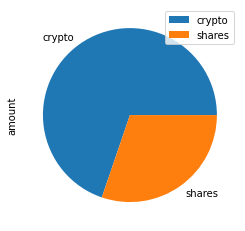

In [14]:
# Plot savings pie chart
df_savings.plot.pie(y='amount')

In [15]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.iloc[0,0] + df_savings.iloc[1,0]

# Validate saving health
if total_savings > emergency_fund:
    print('Congrats! You have enough money in savings to fulfill your emergency fund.')
elif total_savings == emergency_fund:
    print('Congrats! You have met your savings goal.')
else:
    print(f'You are ${emergency_fund - total_savings} away from reaching your target.')

Congrats! You have enough money in savings to fulfill your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [16]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2015-03-17', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-03-17', tz='America/New_York').isoformat()

In [17]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = 1000
).df

# Display sample data
df_stock_data.index = df_stock_data.index.date
df_stock_data.head()

AGG                                             SPY          \
              open      high       low    close     volume    open    high   
2016-03-28  110.15  110.2999  110.0800  110.180  2759202.0     NaN     NaN   
2016-03-29  110.35  110.5700  110.2100  110.525  1689199.0  202.76  205.21   
2016-03-30  110.49  110.5600  110.3055  110.500  2522223.0  206.29  206.87   
2016-03-31  110.52  110.8500  110.5200  110.820  5120808.0  205.91  206.41   
2016-04-01  110.53  110.6599  110.3500  110.540  5013983.0  204.34  207.14   

                                        
               low   close      volume  
2016-03-28     NaN     NaN         NaN  
2016-03-29  202.40  205.15  78767332.0  
2016-03-30  205.59  206.07  67161152.0  
2016-03-31  205.33  205.55  66645503.0  
2016-04-01  203.98  206.89  82800637.0

In [18]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_retirement = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [19]:
# Printing the simulation input data
MC_retirement.portfolio_data

AGG                                                        \
              open      high       low    close      volume daily_return   
2016-03-28  110.15  110.2999  110.0800  110.180   2759202.0          NaN   
2016-03-29  110.35  110.5700  110.2100  110.525   1689199.0     0.003131   
2016-03-30  110.49  110.5600  110.3055  110.500   2522223.0    -0.000226   
2016-03-31  110.52  110.8500  110.5200  110.820   5120808.0     0.002896   
2016-04-01  110.53  110.6599  110.3500  110.540   5013983.0    -0.002527   
...            ...       ...       ...      ...         ...          ...   
2020-03-11  116.70  116.7900  114.5500  114.730  23927880.0    -0.014178   
2020-03-12  113.98  114.7500  109.0600  110.180  33419330.0    -0.039658   
2020-03-13  111.53  112.4643  110.2500  111.910  43574884.0     0.015702   
2020-03-16  111.37  113.9500  111.3700  113.850  19522462.0     0.017335   
2020-03-17  112.89  113.9150  110.5900  110.800  27635606.0    -0.026790   

               SPY                                                    
              open    high     low   close       volume daily_return  
2016-03-28     NaN     NaN     NaN     NaN          NaN          NaN  
2016-03-29  202.76  205.21  202.40  205.15   78767332.0          NaN  
2016-03-30  206.29  206.87  205.59  206.07   67161152.0     0.004485  
2016-03-31  205.91  206.41  205.33  205.55   66645503.0    -0.002523  
2016-04-01  204.34  207.14  203.98  206.89   82800637.0     0.006519  
...            ...     ...     ...     ...          ...          ...  
2020-03-11  280.70  281.94  270.88  274.36  231055382.0    -0.048814  
2020-03-12  256.00  266.66  247.68  248.10  346670590.0    -0.095714  
2020-03-13  263.09  271.08  249.58  270.93  285392181.0     0.092019  
2020-03-16  241.18  256.90  237.36  239.41  261784489.0    -0.116340  
2020-03-17  245.04  256.17  237.07  254.19  231018081.0     0.061735  

[1001 rows x 12 columns]

In [20]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_retirement.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.015683,1.001981,0.996604,1.005967,1.005104,1.008318,0.991648,0.988861,1.002434,0.987311,...,1.001092,0.997057,0.994653,0.997972,1.006791,1.001219,0.993047,1.000250,1.005053,1.007752
2,1.013350,1.002818,0.999690,1.012244,1.010960,1.017450,0.977429,0.997971,0.992329,0.982844,...,0.986323,0.991913,1.002013,0.988131,1.007940,1.004839,0.992510,0.998175,1.006979,1.015608
3,1.014799,1.009755,1.009318,1.010307,1.012590,1.013645,0.967776,1.002530,0.998071,0.978575,...,0.988033,0.987391,1.004713,0.991948,1.004609,1.006163,0.988349,1.004508,1.017343,1.015410
4,1.015440,1.018666,1.004068,1.016447,1.017070,1.025657,0.962224,1.008798,0.998671,0.972778,...,0.989014,0.979862,0.997911,0.988176,1.015631,1.010222,0.984910,1.007819,1.009435,0.999081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,1.983003,3.242721,1.422794,2.127501,3.112723,3.643886,3.286664,2.856096,4.174315,3.876894,...,3.237439,2.465597,1.105092,1.949870,3.906593,3.275739,1.458716,1.676897,3.876972,1.455175
7557,1.985434,3.252364,1.401717,2.150652,3.064670,3.659806,3.315391,2.844670,4.175160,3.881474,...,3.239725,2.455185,1.110230,1.954854,3.917106,3.257911,1.465727,1.693926,3.904492,1.473100
7558,1.976800,3.256921,1.400680,2.187833,3.075995,3.682884,3.351446,2.864388,4.166028,3.913964,...,3.232554,2.453730,1.110360,1.969897,3.964557,3.259201,1.467380,1.704505,3.906194,1.468307
7559,1.986585,3.249813,1.401259,2.187416,3.085606,3.681814,3.384305,2.812125,4.122126,3.906422,...,3.221827,2.468346,1.107022,1.973870,4.009219,3.272971,1.461128,1.712575,3.908275,1.469618


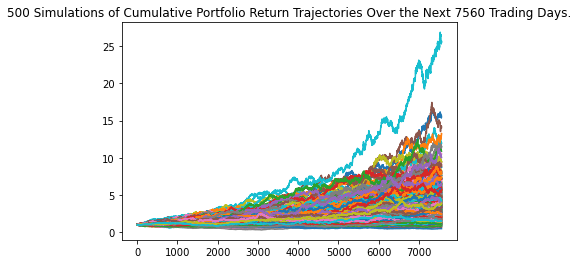

In [21]:
# Plot simulation outcomes
lineplot = MC_retirement.plot_simulation()

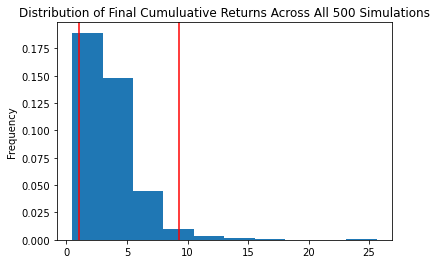

In [22]:
# Plot probability distribution and confidence intervals
distribution = MC_retirement.plot_distribution()

### Retirement Analysis

In [23]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_retirement.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              3.634346
std               2.351131
min               0.473431
25%               2.136183
50%               3.093425
75%               4.295664
max              25.612881
95% CI Lower      1.017235
95% CI Upper      9.261084
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [24]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round((tbl['95% CI Lower']* initial_investment),2)
ci_upper = round((tbl['95% CI Upper']* initial_investment),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $20344.71 and $185221.68


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [25]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round((tbl['95% CI Lower']* initial_investment),2)
ci_upper = round((tbl['95% CI Upper']* initial_investment),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $30517.06 and $277832.52


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [26]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [27]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999498,0.999135,1.001409,1.008610,0.996892,0.987327,0.995648,0.998382,0.987700,1.011357,...,1.001018,0.997820,1.010888,1.002084,0.992974,1.008372,0.995943,0.999903,0.996322,1.005289
2,1.003167,1.012001,1.007925,1.003534,1.000185,0.979461,1.001887,0.999924,0.990188,1.020895,...,1.019518,1.003366,1.009730,1.000017,0.982130,1.014889,1.011792,0.998985,0.992615,1.021598
3,1.008590,1.020386,1.015103,1.006211,0.998834,0.979124,0.994426,1.007995,0.984911,1.034735,...,1.022104,0.996608,1.023152,1.000274,0.981734,1.009677,1.018053,0.984065,0.986499,1.013800
4,1.007642,1.020311,1.017238,1.016290,1.006593,0.993290,0.991221,1.003918,0.986682,1.035375,...,1.028407,0.991234,1.029122,0.993501,0.988719,1.012238,1.033345,0.981591,0.985740,1.021372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.535449,1.377777,1.593046,1.167058,1.399191,0.924935,1.556166,1.786042,1.537239,2.378568,...,0.754227,1.175644,1.120235,1.024826,1.401079,1.550402,1.231317,1.186430,1.887833,0.948538
1257,1.538846,1.387972,1.600022,1.169637,1.395870,0.925487,1.556147,1.760188,1.545522,2.396934,...,0.757574,1.171992,1.113536,1.016943,1.407564,1.540405,1.240240,1.184759,1.886853,0.947155
1258,1.528280,1.375968,1.591090,1.173077,1.408787,0.928632,1.555644,1.748220,1.545581,2.411514,...,0.749285,1.182553,1.101348,1.021161,1.401394,1.541315,1.243751,1.178142,1.880380,0.940321
1259,1.539849,1.385065,1.589674,1.179389,1.415421,0.919330,1.570094,1.742464,1.543684,2.394216,...,0.743282,1.178193,1.092656,1.012905,1.404304,1.532499,1.239674,1.182671,1.863376,0.936481


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

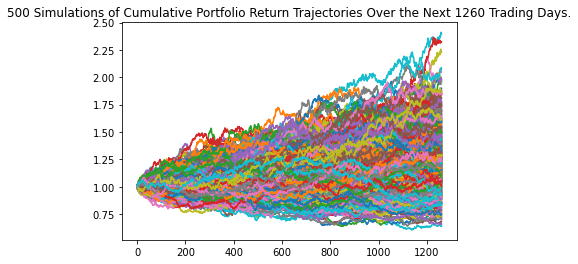

In [29]:
# Plot simulation outcomes
MC_fiveyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

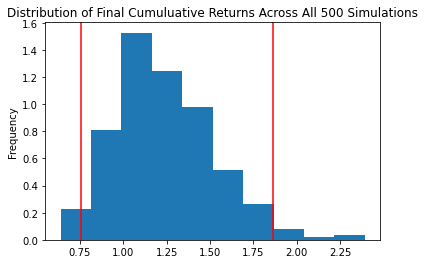

In [30]:
# Plot probability distribution and confidence intervals
MC_fiveyear.plot_distribution()

In [33]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_five = MC_fiveyear.summarize_cumulative_return()
# Print summary statistics
print(tbl_five)

count           500.000000
mean              1.240522
std               0.281923
min               0.638268
25%               1.047392
50%               1.211677
75%               1.409146
max               2.393667
95% CI Lower      0.756921
95% CI Upper      1.865079
Name: 1260, dtype: float64


In [35]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round((tbl_five['95% CI Lower']* initial_investment),2)
ci_upper_five = round((tbl_five['95% CI Upper']* initial_investment),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 5 years will end within in the range of $15138.42 and $37301.59


### Ten Years Retirement Option

In [36]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40, .60],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [39]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.988242,0.984948,0.998964,0.989913,0.996461,1.004407,1.006579,0.998493,0.995512,1.009781,...,1.007432,0.996460,0.995779,0.988748,0.997104,1.002990,1.000275,1.001318,0.995088,1.003908
2,0.986038,0.982143,0.997649,0.993519,1.001754,0.997134,1.005821,1.003916,0.996596,1.000894,...,1.004887,0.991311,1.000683,0.985692,0.998228,0.993286,1.000844,1.004777,1.004304,0.989129
3,0.980370,0.986074,0.994091,0.991009,0.992147,0.988305,1.010111,1.009611,0.996906,1.001393,...,1.002344,0.996085,0.999074,0.969616,1.000188,0.987114,1.001055,1.005558,1.005187,0.994213
4,0.988751,0.987196,0.991459,0.994146,0.996759,0.975842,1.009859,1.005302,1.002695,1.005535,...,0.998402,1.002769,0.995791,0.969225,0.997505,0.986974,0.988502,1.007897,1.012768,0.991807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.209372,4.193152,1.935069,1.703551,1.395854,0.849835,2.230853,1.971504,2.128611,1.006860,...,2.019964,1.447845,2.469505,0.684960,0.836811,1.587238,1.732717,1.386475,1.088308,2.074120
2517,1.207057,4.234747,1.923531,1.704739,1.388313,0.844455,2.241411,1.986818,2.129622,1.001342,...,2.007393,1.451581,2.467784,0.691639,0.837923,1.598760,1.727901,1.387002,1.095495,2.039126
2518,1.209254,4.247854,1.918638,1.706690,1.385796,0.841724,2.244826,1.986900,2.123453,0.991510,...,2.019151,1.452016,2.466551,0.689347,0.834994,1.596305,1.730566,1.385132,1.095760,2.037729
2519,1.206958,4.248054,1.934347,1.704324,1.380124,0.835628,2.249651,1.975453,2.099817,0.994443,...,2.015568,1.466489,2.462552,0.686482,0.838502,1.596001,1.716431,1.381625,1.100481,2.048212


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

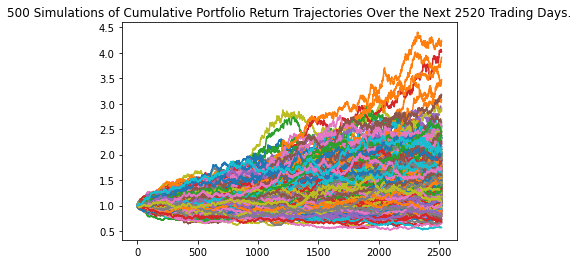

In [40]:
# Plot simulation outcomes
MC_tenyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

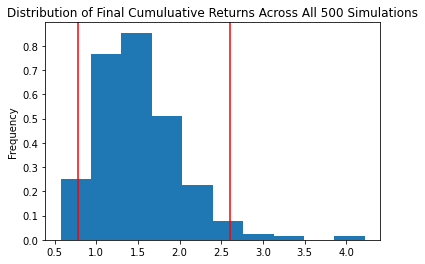

In [42]:
# Plot probability distribution and confidence intervals
MC_tenyear.plot_distribution()

In [44]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_ten = MC_tenyear.summarize_cumulative_return()

# Print summary statistics
print(tbl_ten)

count           500.000000
mean              1.511213
std               0.510218
min               0.571060
25%               1.154149
50%               1.413269
75%               1.768217
max               4.223466
95% CI Lower      0.781855
95% CI Upper      2.603102
Name: 2520, dtype: float64


In [45]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round((tbl_ten['95% CI Lower']* initial_investment),2)
ci_upper_ten = round((tbl_ten['95% CI Upper']* initial_investment),2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 10 years will end within in the range of $15637.09 and $52062.03
